In [29]:
import cv2 as cv
import imageio
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
import numpy as np
from numpy.linalg import lstsq
import scipy
from skimage.feature import plot_matches
from skimage.color import rgb2gray

<Figure size 1440x720 with 0 Axes>

### 1. Detect feature points using Harris corner detection. Describe every key-point by extracting fixed-size patches around it.
- try different sizes and report a short sensitivity analysis of the final result

arguments:
- BlockSize Neighborhood size (see the details on cv.cornerEigenValsAndVecs). default 5.
- KSize Aperture parameter for the cv.Sobel operator. default 3.
- K Harris detector free parameter. See the formula below. default 0.04


Keypoints found in left Image: 6805
Keypoints found in right Image: 6661


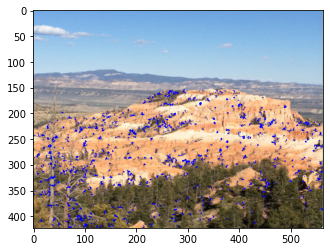

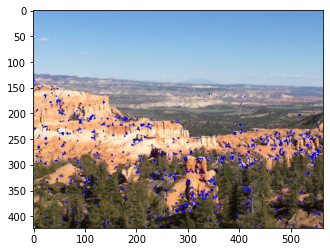

In [30]:
def getHarrisKeypointsFromPath(path, blockSize = 5, ksize=3, k=0.22, peakThreshold=0.01, kpDiameter=20):
    '''
        Function that uses a harris corner detection to extract key points from a given image.
        - BlockSize Neighborhood size (see the details on cv.cornerEigenValsAndVecs). default 5.
        - KSize Aperture parameter for the cv.Sobel operator. default 3.
        - K Harris detector free parameter. See the formula below. default 0.04
    '''
    image = imageio.imread(path)[:,:,:3] # (423, 564, 4); RGBA & alpha channel (transparency)
    grayImage = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    grayImage = np.float32(grayImage)
    dst = cv.cornerHarris(grayImage, blockSize=blockSize, ksize=ksize, k=k)
    resultImage = image.copy() # deep copy image
    # draw the Harris corner features on the image in blue
    resultImage[dst > peakThreshold * dst.max()] = [0, 0, 255]
    # for each dst larger than threshold, make a keypoint out of it
    keypoints = np.argwhere(dst > peakThreshold * dst.max())
    keypointsCV = [cv.KeyPoint(float(x[1]), float(x[0]), kpDiameter) for x in keypoints]

    return image, keypointsCV, keypoints, resultImage

leftImage, leftKeypoints, leftKPforPlotting, leftResult = getHarrisKeypointsFromPath("./sample_images/leftImage.png")
rightImage, rightKeypoints, rightKPforPlotting, rightResult = getHarrisKeypointsFromPath("./sample_images/rightImage.png")

print("Keypoints found in left Image:", len(leftKeypoints))
print("Keypoints found in right Image:", len(rightKeypoints))
# visualize correspondence
plt.imshow(leftResult)
plt.show()
plt.imshow(rightResult)
plt.show()

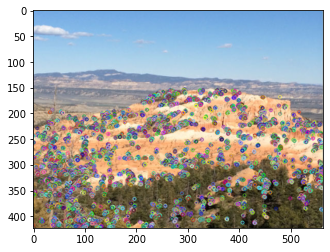

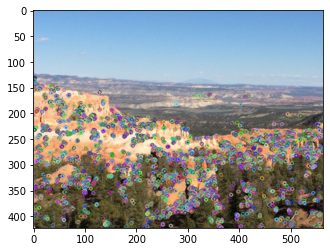

In [31]:
DESCRIPTOR_TYPE = 'SIFT' # 'SIFT' or 'PATCH'
DISTANCE_METRIC='euclidean' # 'correlation' or 'euclidean'
PATCH_SIZE=5

def extractPatchesAsDescriptor(keypoints, image, patchsize):
    '''
        Function that extracts square patches around given corners in image.
        - corners: previously detected keypoints
        - image: the image to extract patches from
        - patchsize: patches of size (patchsize x patchsize)
    '''

    # normalize image for keypoint detection
    grayImage = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    grayImage = np.float32(grayImage)
    patches = []
    leftoverKeypoints = []
    for kp in keypoints:
        x, y = kp.pt
        x = int(x)
        y = int(y)
        # check for out of bounds, discard in case
        if x-patchsize//2 < 0 or y-patchsize//2 < 0 or x+patchsize//2+1 >= grayImage.shape[1] or y+patchsize//2+1 >= grayImage.shape[0]:
            continue

        patch = grayImage[x-patchsize//2:x+patchsize//2+1, y-patchsize//2:y+patchsize//2+1]
        # vectorize
        patch = np.matrix.flatten(patch)/255 # shape (patchsize**2,)
        if patch.shape[0] != patchsize*patchsize:
            continue
        patches.append(patch)
        leftoverKeypoints.append((x,y))

    return np.array(patches), leftoverKeypoints

def extractSiftDescriptors(keypoints, image, plot=True):
    # normalize image for keypoint detection
    img_gray_norm = cv.normalize(image, None, 0, 255, cv.NORM_MINMAX).astype('uint8')

    #sift   
    sift = cv.SIFT_create() 
    #detect keypoints
    descriptors = sift.compute(img_gray_norm, keypoints) # get SIFT descriptors
    if plot:
        img = cv.drawKeypoints(image, keypoints, image)
        plt.imshow(img)
        plt.show()
    return descriptors[1]

if DESCRIPTOR_TYPE == 'SIFT':
    leftDescriptors = extractSiftDescriptors(leftKeypoints, leftResult)
    rightDescriptors = extractSiftDescriptors(rightKeypoints, rightResult)
else:
    leftDescriptors, leftKeypoints = extractPatchesAsDescriptor(leftKeypoints, leftImage,patchsize=PATCH_SIZE)
    rightDescriptors, rightKeypoints = extractPatchesAsDescriptor(rightKeypoints, rightImage,patchsize=PATCH_SIZE)
    

### 3. Compute the distances between every descriptor in image 1 with every descriptor in image 2. 
Use: 

a) Normalized correlation

b) Euclidean distance 

after normalizing each descriptor.

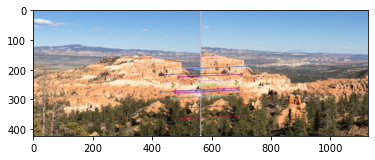

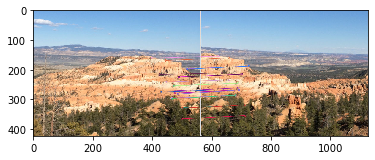

In [32]:
# This Code is just too slow for 30.000 x 30.000 keypoint matrix... <- instead a BF matcher is used
# even when optimizing the code, since its a symmetric matrix. It would still be too slow...
def calculateDistanceMatrix(descriptors1, descriptors2):
    result = np.zeros((descriptors1.shape[0], descriptors2.shape[0])) # number of peaks in 1 x peaks in 2
    if DISTANCE_METRIC == 'euclidean':
        for i in range(descriptors1.shape[0]):
            if i % 100 == 0:
                print(i/(descriptors1.shape[0]))
            for j in range(descriptors2.shape[0]):
                desc1 = descriptors1[i]/np.linalg.norm(descriptors1[i]) # normalized
                desc2 = descriptors2[j]/np.linalg.norm(descriptors2[j]) # normalized
                result[i,j] = np.linalg.norm(desc1 - desc2)
        return result
    elif DISTANCE_METRIC == 'correlation':
        for i in range(descriptors1.shape[0]):
            for j in range(descriptors2.shape[0]):
                desc1 = descriptors1[i]/np.linalg.norm(descriptors1[i]) # normalized
                desc2 = descriptors2[j]/np.linalg.norm(descriptors2[j]) # normalized
                result[i,j] = sum(scipy.signal.correlate(desc1, desc2, mode='full', method='auto'))
        return result/ np.max(result) # not sure if this is what is mean with "normalized"
    else:
        print("WARNING: Unknown distance measure.")
        return -1

def calculateDistanceVector(A, t, points1, points2):
    if A is not None and t is not None:
        # point estimation
        pts_est = np.dot(A, points1) + t
        # calc euclidian distance
        squared_diff = np.power(pts_est - points2, 2)
        euc_dist = np.sqrt(np.sum(squared_diff, axis=0))
    else:
        euc_dist = None
    return euc_dist

# Code above is just too slow for 30.000 x 30.000 keypoint matrix...
def findMatchingKeypointDescriptors(leftImage, leftKeypoints, leftDescriptors, rightImage, rightKeypoints, rightDescriptors, ratio=0.8, plot=True):
    # BFMatcher with default params
    bf = cv.BFMatcher() # Uses L2 norm as distance
    matchedDescriptors = bf.knnMatch(leftDescriptors, rightDescriptors, k=2) # finds closest k-matches of descriptors

    # Apply ratio test, for selection
    selected = []
    for m,n in matchedDescriptors: 
        if m.distance < ratio*n.distance: # uses euclidean distance
            selected.append([m])

    if plot:
        match_img = cv.drawMatchesKnn(leftImage, leftKeypoints, rightImage, rightKeypoints, selected, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(match_img)
        fig1 = plt.figure() # create a figure with the default size 
        ax1 = fig1.add_subplot(1,1,1) 
        ax1.imshow(match_img, interpolation='none')
        fig1.savefig('correspondance.png', dpi = 1000) # change the resolution of the saved image

        plt.show()
    
    selected = [m[0] for m in selected]
    return selected
    
if DESCRIPTOR_TYPE == 'SIFT':
    matches = findMatchingKeypointDescriptors(leftImage, leftKeypoints, leftDescriptors, rightImage, rightKeypoints, rightDescriptors)
    leftKeypoints = np.float32([leftKeypoints[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    rightKeypoints = np.float32([rightKeypoints[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    leftKPforPlotting = np.float32([leftKPforPlotting[m.queryIdx] for m in matches])
    rightKPforPlotting = np.float32([rightKPforPlotting[m.trainIdx] for m in matches])
    leftKeypointCoords = np.array([[x[0][0] for x in leftKeypoints], [y[0][1] for y in leftKeypoints]])
    rightKeypointCoords = np.array([[x[0][0] for x in rightKeypoints], [y[0][1] for y in rightKeypoints]])
else:
    # This Code is just too slow for 30.000 x 30.000 keypoint matrix... <- I use instead a BF matcher with SIFT descriptors
    distances = calculateDistanceMatrix(leftDescriptors, rightDescriptors, metric = 'euclidean')
    #distances = calculateDistanceMatrix(leftDescriptors, rightDescriptors, metric = 'correlation')

#distances = calculateDistanceMatrix(leftDescriptors, rightDescriptors, metric = 'euclidean')
#distances = calculateDistanceMatrix(leftDescriptors, rightDescriptors, metric = 'correlation')

### 4. Select the best matches based on a threshold or by considering the top few hundred pairs of descriptors. Also, make a sensitivity analysis based on these parameters.

In [33]:
# Since the BFMatcher, calcultes all distances internally and matches with KNNmatcher this code is not needed.
def thresholding(distances, top_n = 200, max_distance_threshold=0.5):
    selectedPairs = []
    distanceSum = 0
    while len(selectedPairs) < top_n and len(selectedPairs) < len(distances) and distances.min() < max_distance_threshold:
        selectedPairs.append(np.array(list(np.unravel_index(distances.argmin(), distances.shape))))
        # set selected to max
        distanceSum += distances.min()
        distances[selectedPairs[-1]] = float("inf")
    return np.array(selectedPairs), distanceSum/len(selectedPairs)

if DESCRIPTOR_TYPE != 'SIFT':
    indices, _ = thresholding(distances)
    leftKeypoints = np.float32([leftKeypoints[i] for i in indices]).reshape(-1,1,2)
    rightKeypoints = np.float32([rightKeypoints[i] for i in indices]).reshape(-1,1,2)
    leftKeypointCoords = np.array([[x[0][0] for x in leftKeypoints], [y[0][1] for y in leftKeypoints]])
    rightKeypointCoords = np.array([[x[0][0] for x in rightKeypoints], [y[0][1] for y in rightKeypoints]])


### 5. Make a simple implementation of RANSAC to estimate an Affine transformation mapping one image onto the other.
- you need 3-5 matches of points to initialize the estimation of the transformation. 

- Evaluate the obtained transformation by fitting the other points against the model and compute the ratio of inliers/outliers. 

- For finding a good transformation, you need to consider a number of iterations, with different random initializations of the algorithm. 

- Report the number of inliers and outliers and the average residual for the inliers
    - the squared distance between the point coordinates in one image, 
    - and the transformed coordinates of the matching points in the other image). 
    
- Display the location of the inliers matches on both images.

Ransac implementation adapted from: https://github.com/quqixun/ImageRegistration/blob/master/affine_transform.py

In [34]:
def estimateAffineFromPoints(leftPoints, rightPoints):
    """
        Returns: A, t matrices of estimated affine transformation, given 3-5 point pairs from the left and right image
        - uses least-squares
    """
    # Get the number of points
    totalPoints = leftPoints.shape[1]

    # Initialize matrix M with 6 columns (affine transformation has 6 parameters)
    M = np.zeros((2 * totalPoints, 6))

    for i in range(totalPoints):
        # Form the matrix M
        tmp = [[leftPoints[0, i], leftPoints[1, i], 0, 0, 1, 0],
                [0, 0, leftPoints[0, i][0], leftPoints[1, i][0], 0, 1]]
        M[2 * i: 2 * i + 2, :] = np.array(tmp, dtype=object)

    # Form the matrix b, containing all known target points
    b = rightPoints.T.reshape((2 * totalPoints, 1))

    try:
        # Solve the linear equation with least squares method
        theta = lstsq(M, b, rcond=None)[0]
        A = theta[:4].reshape((2, 2))
        t = theta[4:]
    except np.linalg.linalg.LinAlgError: # M is singular matrix
        A = None
        t = None

    # M = np.hstack((A, t))
    return A, t

def estimateAffineWithRansac(leftKeypoints, rightKeypoints, iterations = 2000, min_points = 4, threshold = 10):
    '''
        Function that robustly estimates an affine transformation between 2 images with Ransac
    '''

    # Initialize the number of inliers
    inliers_candidate = 0

    # Initialize the affine transformation A and t,
    # and a vector that stores indices of inliers
    A_best= None
    t_best= None
    inliers_best = None
    best_average_distance = None # quality

    for _ in range(iterations):
        # Randomly pick 'min_points' points 
        idx = np.random.randint(0, leftKeypoints.shape[1], (min_points, 1))
        # Estimate affine transformation by these points

        A_candidate, t_candidate = estimateAffineFromPoints(leftKeypoints[:, idx], rightKeypoints[:, idx])

        # we are looking to minimize the distance between points, given a candidate transformation
        # Calculate the euclidean distances of pointpairs 
        distances = calculateDistanceVector(A_candidate, t_candidate, leftKeypoints, rightKeypoints)        
        if distances is not None and len(distances) >= min_points:
            # count the inliers within the threshold
            inliers_candidate = np.where(distances < threshold)
            # Obtain the number of inliers
            num_inliers_candidate = len(inliers_candidate[0])

            # keep track of best Affine transform found so far
            if inliers_best is None or num_inliers_candidate > len(inliers_best[0]):
                # Update the number of inliers
                inliers_best = inliers_candidate
                # Set returned value
                A_best = A_candidate
                t_best = t_candidate
                best_average_distance = np.average(distances)
        else:
            pass
        
    if inliers_best is None:
        best_average_distance = float("inf")
        inliers_best = [float("inf")]

    return A_best, t_best, inliers_best[0], best_average_distance

A, t, inliers, avg_distance = estimateAffineWithRansac(leftKeypointCoords, rightKeypointCoords, 1000, min_points=4, threshold=1.6)

### 6. Warp image 2 onto image 1 using the best estimated transformation with the highest number of inliers.

RANSAC-own:
M [[ 9.56461513e-01  2.11138252e-02 -3.35478235e+02]
 [-3.18869156e-02  9.81054838e-01  1.10346311e+01]]
inliers [ 2  3  5  6  7  8  9 10 11 13 14 17 18 19 21 22 24 25 26]
Average keypoint distance 2.173682944133477


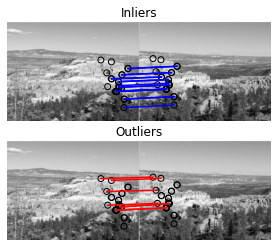

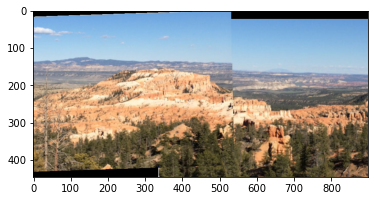

In [35]:
def stitchImagesWithTransformation(leftImage, rightImage, M):
    #stitching
    transformation = M[:2,-1]
    transformation = np.abs(transformation)
    H = np.vstack((M,[0,0,1]))
    margin = np.max(transformation)
    height, width, _ = rightImage.shape
    newShape = (int(height+2*margin), int(width+2*margin))
    alignment=np.eye(3)
    alignment[:2, 2] = margin, margin
    img_right_warped = cv.warpPerspective(rightImage, alignment, newShape, borderMode=cv.BORDER_TRANSPARENT)
    img_left_warped = cv.warpPerspective(leftImage, H.dot(alignment), newShape, borderMode=cv.BORDER_TRANSPARENT)
    mask = np.where(img_left_warped == 0)
    img_left_warped[mask] = img_right_warped[mask]

    def recursiveCrop(frame):
        if not np.sum(frame[0]):
            return recursiveCrop(frame[1:])
        if not np.sum(frame[:,0]):
            return recursiveCrop(frame[:,1:])
        if not np.sum(frame[-1]):
            return recursiveCrop(frame[:-2])
        if not np.sum(frame[:,-1]):
            return recursiveCrop(frame[:,:-2])
        return frame

    return recursiveCrop(img_left_warped)

def visualizeCorrespondence(leftImage, rightImage, src, dst, inliers, outliers):
    # visualize correspondence
    fig, ax = plt.subplots(nrows=2, ncols=1)
    leftImage = rgb2gray(leftImage)
    rightImage = rgb2gray(rightImage)
    plt.gray()

    inlier_idxs = np.nonzero(inliers)[0]
    plot_matches(ax[0], leftImage, rightImage, src, dst,
                np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
    ax[0].axis('off')
    ax[0].set_title('Inliers')

    outlier_idxs = np.nonzero(outliers)[0]
    plot_matches(ax[1], leftImage, rightImage, src, dst,
                np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
    ax[1].axis('off')
    ax[1].set_title('Outliers')

    fig.savefig('correspondance_SW.png', dpi = 1000) # change the resolution of the saved image
    plt.show()

inliers_mask = np.zeros((len(leftKeypoints)))
inliers_mask[inliers] = True

M = np.hstack((A, t))
stitchedImage = stitchImagesWithTransformation(leftImage, rightImage, M) 
# Transform image
print("RANSAC-own:")
print('M', M)
print('inliers', inliers)
print('Average keypoint distance', avg_distance)

# visualize Correspondence
visualizeCorrespondence(leftImage, rightImage, leftKPforPlotting, rightKPforPlotting, inliers_mask, inliers_mask == False) 

plt.imshow(stitchedImage)


# Complete Pipeline (see below to test code with new images)

Keypoints found in left Image: 53851
Keypoints found in right Image: 92318


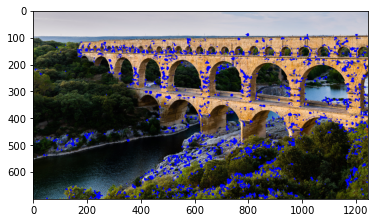

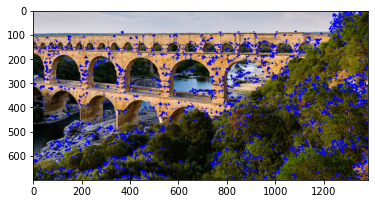

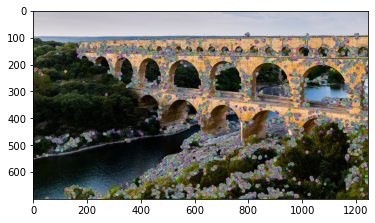

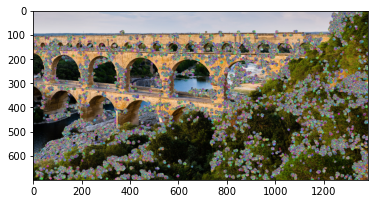

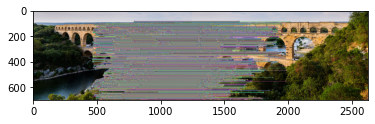

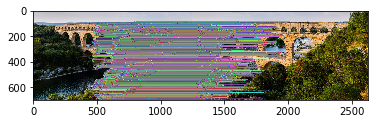

Keypoints after Matching/Thresholding: 17590
RANSAC-own:
M [[ 1.00000000e+00 -2.02060590e-14 -4.29000000e+02]
 [ 2.27373675e-13  1.00000000e+00 -8.35616869e-11]]
inliers [    0     1     2 ... 17587 17588 17589]
Average keypoint distance 0.02438436636224114


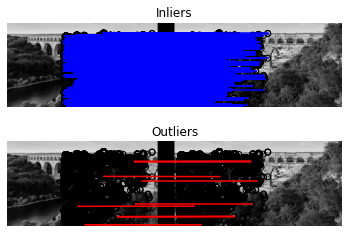

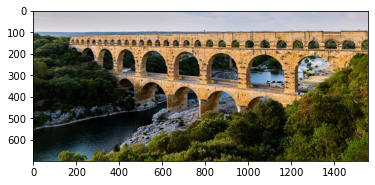

In [36]:
#### Code to read from folder and stitch images

DISTANCE_METRIC='euclidean' # 'correlation'
DESCRIPTOR_TYPE = 'SIFT' # 'SIFT' or 'PATCH'
PATCH_SIZE=5

# Stitch image
def stitchImages(imagePath1, imagePath2, blockSize = 9, ksize=7, k=0.20, peakPercent=0.01, kpDiameter=13, ratio=0.75, iterations=3000,threshold_residual=10, verbose=True): # TODO: ANALYSIS
  leftImage, leftKeypoints, leftKPforPlotting, leftResult = getHarrisKeypointsFromPath(imagePath1, blockSize, ksize, k, peakPercent, kpDiameter=kpDiameter)
  rightImage, rightKeypoints, rightKPforPlotting, rightResult = getHarrisKeypointsFromPath(imagePath2, blockSize, ksize, k, peakPercent, kpDiameter=kpDiameter)

  if verbose:
    print("Keypoints found in left Image:", len(leftKeypoints))
    print("Keypoints found in right Image:", len(rightKeypoints))
    plt.imshow(leftResult)
    plt.show()
    plt.imshow(rightResult)
    plt.show()

  if DESCRIPTOR_TYPE == 'SIFT':
      leftDescriptors = extractSiftDescriptors(leftKeypoints, leftResult, plot=verbose)
      rightDescriptors = extractSiftDescriptors(rightKeypoints, rightResult, plot=verbose)
      matches = findMatchingKeypointDescriptors(leftImage, leftKeypoints, leftDescriptors, rightImage, rightKeypoints, rightDescriptors, ratio=ratio, plot=verbose)
      
      leftKeypoints = np.float32([leftKeypoints[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
      rightKeypoints = np.float32([rightKeypoints[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
      leftKPforPlotting = np.float32([leftKPforPlotting[m.queryIdx] for m in matches])
      rightKPforPlotting = np.float32([rightKPforPlotting[m.trainIdx] for m in matches])
      leftKeypointCoords = np.array([[x[0][0] for x in leftKeypoints], [y[0][1] for y in leftKeypoints]])
      rightKeypointCoords = np.array([[x[0][0] for x in rightKeypoints], [y[0][1] for y in rightKeypoints]])

  else: # This takes forever for 12000 x 12000 keypoints, please use SIFT descriptors instead, Thanks :)
      print("Distance calculation for patches takes forever for 12000 x 12000 keypoints, please use SIFT descriptors instead, Thanks :)")
      leftDescriptors, leftKeypoints = extractPatchesAsDescriptor(leftKeypoints, leftImage,patchsize=PATCH_SIZE)
      rightDescriptors, rightKeypoints = extractPatchesAsDescriptor(rightKeypoints, rightImage,patchsize=PATCH_SIZE)
      distances = calculateDistanceMatrix(leftDescriptors, rightDescriptors)  
      indices, _ = thresholding(distances)
      leftKeypoints = np.float32([leftKeypoints[i] for i in indices]).reshape(-1,1,2)
      rightKeypoints = np.float32([rightKeypoints[i] for i in indices]).reshape(-1,1,2)
      leftKeypointCoords = np.array([[x[0][0] for x in leftKeypoints], [y[0][1] for y in leftKeypoints]])
      rightKeypointCoords = np.array([[x[0][0] for x in rightKeypoints], [y[0][1] for y in rightKeypoints]])


  
  # robustly estimate affine transform model with RANSAC
  A, t, inliers, avg_distance = estimateAffineWithRansac(leftKeypointCoords, rightKeypointCoords, iterations, min_points=4, threshold=threshold_residual)  
  if avg_distance == float('inf') or inliers is None:
    return -1, avg_distance, 0
  inliers_mask = np.zeros((len(leftKeypoints)))
  inliers_mask[inliers] = True
  
  M = np.hstack((A, t))
  stitchedImage = stitchImagesWithTransformation(leftImage, rightImage, M) 
  if verbose:
    print("Keypoints after Matching/Thresholding:", len(leftKeypoints))
    # Transform image
    print("RANSAC-own:")
    print('M', M)
    print('inliers', inliers)
    print('Average keypoint distance', avg_distance)

    # visualize Correspondence
    visualizeCorrespondence(leftImage, rightImage, leftKPforPlotting, rightKPforPlotting, inliers_mask, inliers_mask == False) 
  
    plt.imshow(stitchedImage)

  return stitchedImage, avg_distance, len(inliers)

stitchedImage, avg_distance, num_inliers = stitchImages("./sample_images/leftImage2.png",  # Takes approx 1.5 minutes
                                          "./sample_images/rightImage2.png", 
                                          blockSize = 9, 
                                          ksize=7,
                                          k=0.2,
                                          peakPercent=0.01,
                                          kpDiameter=13,
                                          ratio=0.75,
                                          threshold_residual=2)                     

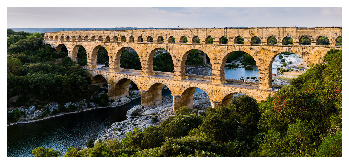

In [37]:
# Save image
def saveImage(image, pathWithName):
    fig1 = plt.figure() # create a figure with the default size 
    ax1 = fig1.add_subplot(1,1,1) 
    ax1.axis('off')
    ax1.imshow(image, interpolation='none')
    fig1.savefig(pathWithName, dpi = 1000) # change the resolution of the saved image

saveImage(stitchedImage, "./stitched_images/Stitched.png")


# Testing with new Images

Please write here the pairs of paths to the images you would like to stitch run the code below.

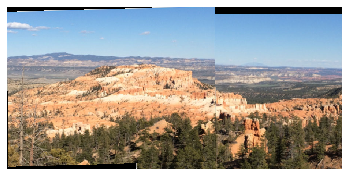

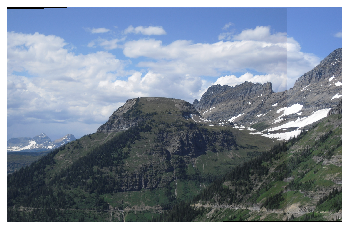

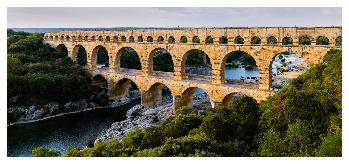

In [38]:
showAllIntermediateImages = False
# Disclaimer: This can take a few minutes, depending on the number of keypoints found per images.
pathPairs = [("./sample_images/leftImage.png", "./sample_images/rightImage.png"),
             #("./sample_images/uttower_left.jpg", "./sample_images/uttower_right.jpg"), # finds a good transformation but does not stitch correctly...
             ("./sample_images/leftMountain.jpg", "./sample_images/rightMountain.jpg"),
             ("./sample_images/leftImage2.png", "./sample_images/rightImage2.png")] # <- its a nice one but takes 1.5 minutes...

for i, pair in enumerate(pathPairs):
    stitchedImage, avg_distance, num_inliers = stitchImages(pair[0],
                                                            pair[1],
                                                            blockSize = 9, 
                                                            ksize=7,
                                                            k=0.2,
                                                            peakPercent=0.01,
                                                            ratio=0.85,
                                                            kpDiameter=13,
                                                            threshold_residual=2,
                                                            verbose=showAllIntermediateImages)
    # Save image
    stitchedPath = "./stitched_images/Stitched"+ str(i+1) +".png"
    saveImage(stitchedImage, stitchedPath)


# Experiments
## Harris Corner Detection Parameters

In [ ]:
# Plotting
def plot_results(x, y, color, ylabel='', title='', parameter=''):
    fontsize = 14
    plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
    plt.rc('axes', labelsize=fontsize)     # fontsize of the axes title
    plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
    plt.rc('legend', fontsize=fontsize)    # legend fontsize

    plt.xlabel('Parameter Value ' + parameter)
    plt.ylabel(ylabel)
    plt.plot(x, y, color=color)
    plt.title(title)
    #plt.legend(loc='upper center', bbox_to_anchor=(0.4, 1.8), ncol=2, fancybox=True, shadow=True)
    plt.show()

In [ ]:
avg_distances = []
num_inliers = []

for k in np.linspace(0.1, 0.24, 15):
    stitchedImage, avg_distance, inliers = stitchImages("./sample_images/leftImage.png", "./sample_images/rightImage.png", blockSize = 5, ksize=3, k=k, verbose=False)
    print(k, ":", avg_distance)
    avg_distances.append(avg_distance)
    num_inliers.append(inliers)

0.1 : inf
0.11 : 0.4028277239717971
0.12 : inf
0.13 : inf
0.14 : 0.2576941016065825
0.15 : 1.3501805234163926
0.16 : 1.4384262995639543
0.16999999999999998 : 1.1803323438904745
0.18 : 2.233024410738164
0.19 : 1.7199863875370927
0.19999999999999998 : 1.297071786684614
0.21 : 3.020481411284255
0.21999999999999997 : 2.293495569942969
0.22999999999999998 : 2.372201311634156
0.24 : 2.885919237529588


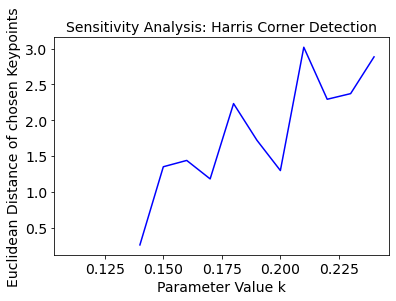

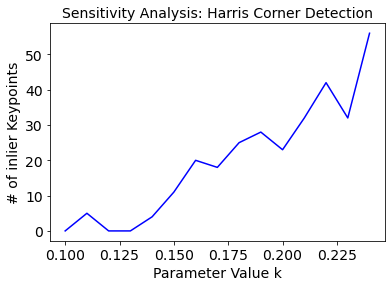

In [ ]:
plot_results(np.linspace(0.1, 0.24, 15), avg_distances, 'blue', ylabel='Euclidean Distance of chosen Keypoints', title='Sensitivity Analysis: Harris Corner Detection', parameter='k')
plot_results(np.linspace(0.1, 0.24, 15), num_inliers, 'blue', ylabel='# of inlier Keypoints', title='Sensitivity Analysis: Harris Corner Detection', parameter='k')

In [ ]:
avg_distances = []
num_inliers = []
k = 0.2
for blocksize in range(3,9+1,2):
    stitchedImage, avg_distance, inliers = stitchImages("./sample_images/leftImage.png", "./sample_images/rightImage.png", blockSize = blocksize, ksize=3, k=k, verbose=False)
    print(blocksize, ":", avg_distance)
    avg_distances.append(avg_distance)
    num_inliers.append(inliers)

3 : 2.2398847744821095
5 : 1.9049949226857543
7 : 0.44861263772860366
9 : 0.4590872422441256


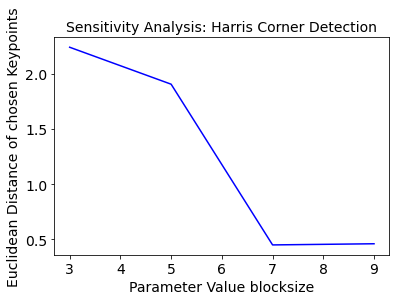

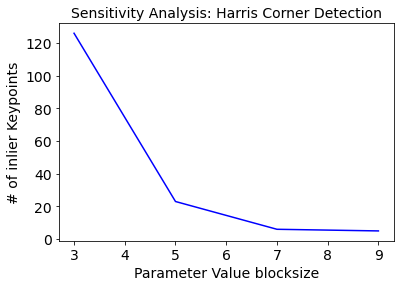

In [ ]:
plot_results(range(3,9+1,2), avg_distances, 'blue', ylabel='Euclidean Distance of chosen Keypoints', title='Sensitivity Analysis: Harris Corner Detection', parameter='blocksize')
plot_results(range(3,9+1,2), num_inliers, 'blue', ylabel='# of inlier Keypoints', title='Sensitivity Analysis: Harris Corner Detection', parameter='blocksize')

In [ ]:

avg_distances = []
num_inliers = []
k = 0.2
blocksize = 9
for ksize in range(3,9+1,2):
    stitchedImage, avg_distance, inliers = stitchImages("./sample_images/leftImage.png", "./sample_images/rightImage.png", blockSize = blocksize, ksize=ksize, k=k, verbose=False)
    print(ksize, ":", avg_distance)
    avg_distances.append(avg_distance)
    num_inliers.append(inliers)

3 : 0.3700805320036647
5 : 0.7150286403869521
7 : 2.9137862566508537e-12
9 : 0.12073175700548622


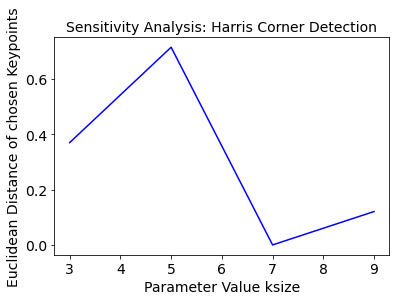

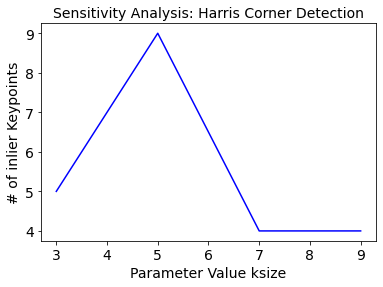

In [ ]:
plot_results(range(3,9+1,2), avg_distances, 'blue', ylabel='Euclidean Distance of chosen Keypoints', title='Sensitivity Analysis: Harris Corner Detection', parameter='ksize')
plot_results(range(3,9+1,2), num_inliers, 'blue', ylabel='# of inlier Keypoints', title='Sensitivity Analysis: Harris Corner Detection', parameter='ksize')

In [ ]:
avg_distances = []
num_inliers = []

k = 0.2
blocksize = 9
ksize=7
for kpd in np.linspace(3, 15, 13):
    stitchedImage, avg_distance, inliers = stitchImages("./sample_images/leftImage.png", "./sample_images/rightImage.png", blockSize = blocksize, ksize=ksize, k=k, kpDiameter=kpd, verbose=False)
    print(kpd, ":", avg_distance)
    avg_distances.append(avg_distance)
    num_inliers.append(inliers)

3.0 : 1.1253523872937128
4.0 : 1.5105721881959553
5.0 : 1.395717531902688
6.0 : 1.1618347055335807
7.0 : 0.7639423637625312
8.0 : 0.33411730362950565
9.0 : 0.4244083979202788
10.0 : 0.5758975079936891
11.0 : 1.488607386034831
12.0 : 0.7085230254665987
13.0 : 3.901952082022266e-12
14.0 : 7.721490411637374e-12
15.0 : 6.9192190233083715e-12


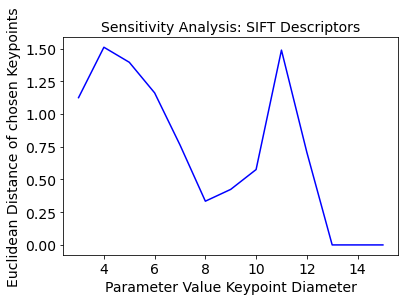

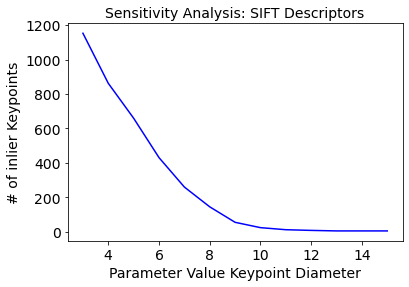

In [ ]:
plot_results(np.linspace(3, 15, 13), avg_distances, 'blue', ylabel='Euclidean Distance of chosen Keypoints', title='Sensitivity Analysis: SIFT Descriptors', parameter='Keypoint Diameter')
plot_results(np.linspace(3, 15, 13), num_inliers, 'blue', ylabel='# of inlier Keypoints', title='Sensitivity Analysis: SIFT Descriptors', parameter='Keypoint Diameter')

## Matching/Thresholding Parameters

In [ ]:
avg_distances = []
num_inliers = []
k = 0.2
blocksize = 9
ksize=7

for ratio in np.linspace(0.7, .9, 9):
    stitchedImage, avg_distance, inliers = stitchImages("./sample_images/leftImage.png", "./sample_images/rightImage.png", blockSize = blocksize, ksize=ksize, k=k,ratio=ratio, verbose=False)
    print(ratio, ":", avg_distance)
    avg_distances.append(avg_distance)
    num_inliers.append(inliers)

0.7 : 7.885357215129337e-12
0.725 : 3.107844979853548e-12
0.75 : 2.863067382005499e-13
0.775 : 1.745738501649649
0.8 : 0.9210059396614899
0.825 : 1.037870971840956
0.85 : 0.972533681690031
0.875 : 1.6060318883084048
0.9 : 1.2536466434745783


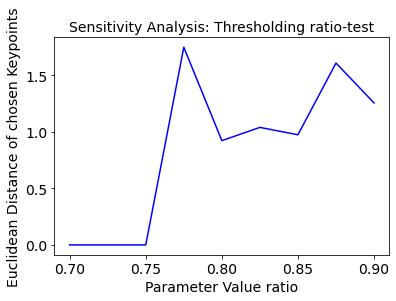

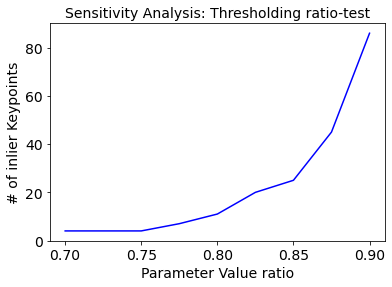

In [ ]:
plot_results(np.linspace(0.7, .9, 9), avg_distances, 'blue', ylabel='Euclidean Distance of chosen Keypoints', title='Sensitivity Analysis: Thresholding ratio-test', parameter='ratio')
plot_results(np.linspace(0.7, .9, 9), num_inliers, 'blue', ylabel='# of inlier Keypoints', title='Sensitivity Analysis: Thresholding ratio-test', parameter='ratio')

## Ransac Parameters

In [ ]:
avg_distances = []
num_inliers = []
k = 0.2
blocksize = 9
ksize=7
ratio=0.8

for threshold_residual in np.linspace(0.5, 3, 21):
    stitchedImage, avg_distance, inliers = stitchImages("./sample_images/leftImage.png", "./sample_images/rightImage.png", blockSize = blocksize, ksize=ksize, k=k,ratio=ratio, threshold_residual=threshold_residual, verbose=False)
    print(threshold_residual, ":", avg_distance)
    avg_distances.append(avg_distance)
    num_inliers.append(inliers)

0.5 : 4.147178735353947
0.625 : 4.028127139394159
0.75 : 4.427195325756856
0.875 : 4.128199610736572
1.0 : 4.393363924525443
1.125 : 4.301678229889689
1.25 : 0.9210059396611392
1.375 : 4.454067113006878
1.5 : 0.9651799994725796
1.625 : 0.8437194660073918
1.75 : 0.8575744643689908
1.875 : 0.9425241675946076
2.0 : 0.9425241675957211
2.125 : 1.0393042747603145
2.25 : 0.896467296732721
2.375 : 0.8868468777645352
2.5 : 0.9785947142538689
2.625 : 1.0118094288633075
2.75 : 1.0418385396845535
2.875 : 0.9064669068646343
3.0 : 1.1890308429447538


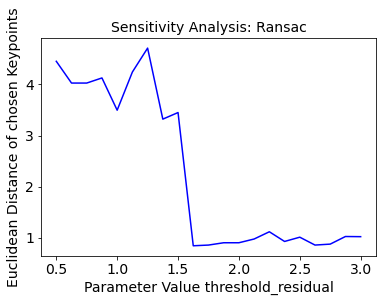

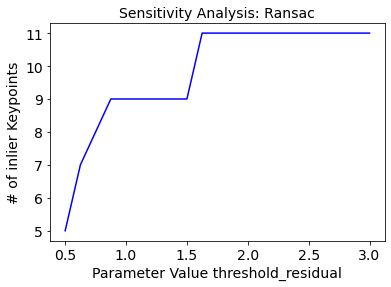

In [ ]:
plot_results(np.linspace(0.5, 3, 21), avg_distances, 'blue', ylabel='Euclidean Distance of chosen Keypoints', title='Sensitivity Analysis: Ransac', parameter='threshold_residual')
plot_results(np.linspace(0.5, 3, 21), num_inliers, 'blue', ylabel='# of inlier Keypoints', title='Sensitivity Analysis: Ransac', parameter='threshold_residual')